In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [20]:
df_R = pd.read_csv(filepath_or_buffer = 'data/CompleteCal_shift.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     CO_ppm  NO_ppb  NO2_ppb  O3_ppb
Date                                                
2014-07-07 07:13:00     0.2     1.1     13.4      28
2014-07-07 07:14:00     0.3     1.2     13.8      28
2014-07-07 07:15:00     0.3     1.2     14.4      26
2014-07-07 07:16:00     0.3     1.3     14.9      25
2014-07-07 07:17:00     0.3     7.8     17.9      24


##Import Pod Data

In [21]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D3_clean.csv', parse_dates = [0], index_col = 0)
print df_P[:5]

                       UnixTime  e2v03  Temp    Rh
YYYY/MM/DD_HH:MM:SS                               
2014-07-07 21:08:01  1404767281    101  44.6  10.0
2014-07-07 21:08:22  1404767302    101  44.7  10.0
2014-07-07 21:08:43  1404767323    101  44.6  10.0
2014-07-07 21:09:04  1404767344    101  44.7  10.1
2014-07-07 21:09:24  1404767364    101  44.7  10.2


###Resample all of the data, so that the reference, pod, and solar data are in the same dataframe, and also average over a specified time.

In [22]:
resamp_time = '1Min'

In [23]:
df_all = pd.concat([df_R.O3_ppb.resample(resamp_time), df_P.resample(resamp_time)], axis=1).dropna()
print df_all[:5]

                     O3_ppb      UnixTime       e2v03       Temp         Rh
Date                                                                       
2014-07-07 21:08:00      68  1.404767e+09  101.000000  44.633333  10.000000
2014-07-07 21:09:00      70  1.404767e+09  100.666667  44.700000  10.133333
2014-07-07 21:10:00      71  1.404767e+09  102.000000  44.766667  10.233333
2014-07-07 21:11:00      67  1.404767e+09  105.333333  44.766667  10.366667
2014-07-07 21:12:00      63  1.404768e+09  104.666667  44.800000  10.200000


####Create 'days since start' feature.

In [24]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [25]:
df_fit = df_all.dropna()

In [26]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [27]:
def plot_data(data, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data, marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [28]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [29]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y_data, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Reference Data
[ 43.  35.  26.  34.  28.]


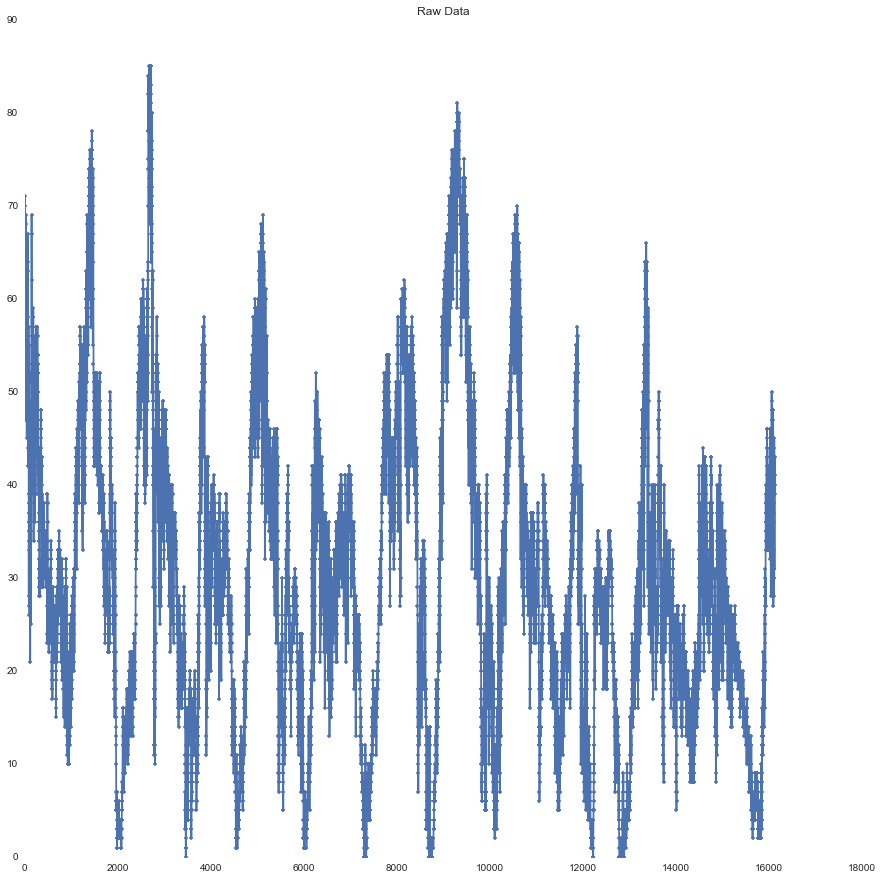

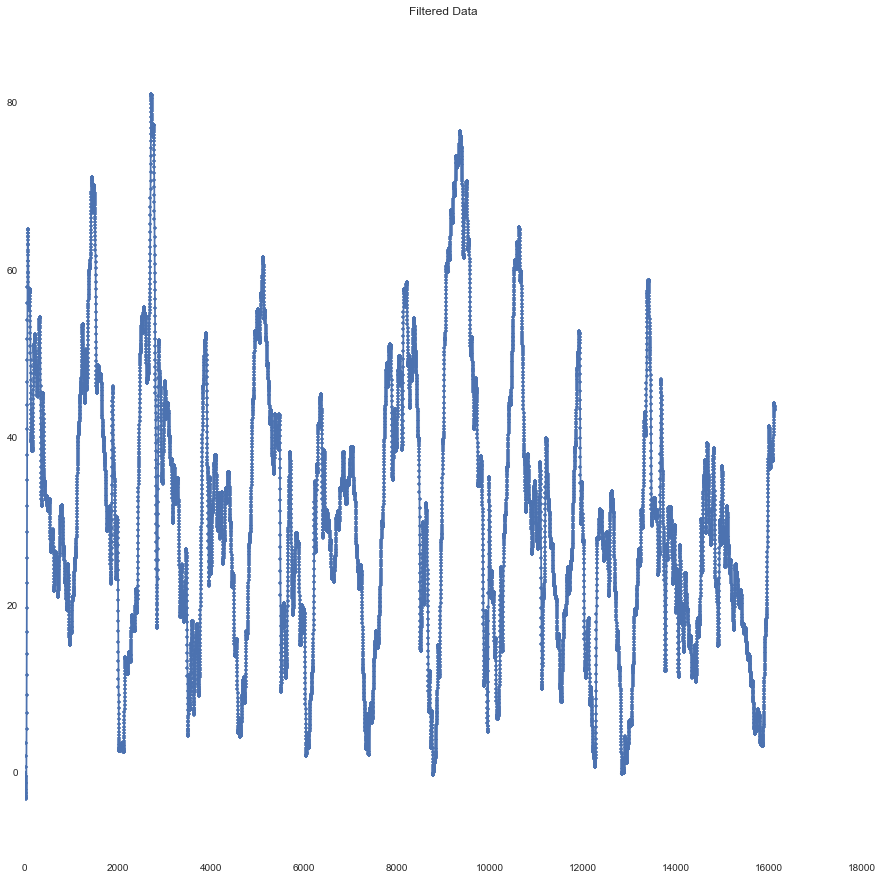

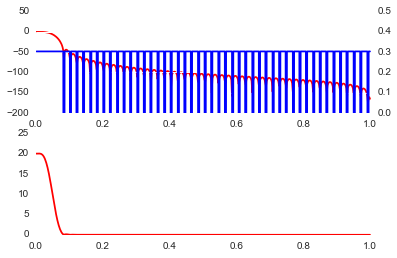

In [30]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 100
filter_minutes = 20

ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
print 'Reference Data'
print ref_o3_sm[:5]

#pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
#print 'Pod Data'
#print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [31]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                     O3_ppb      UnixTime       e2v03  Temp         Rh  \
Date                                                                     
2014-07-07 22:55:00      43  1.404774e+09   98.666667  42.4  10.466667   
2014-07-07 22:56:00      35  1.404774e+09  100.333333  42.4  10.433333   
2014-07-07 22:57:00      26  1.404774e+09  106.333333  42.4  10.400000   
2014-07-07 22:58:00      34  1.404774e+09   99.500000  42.4  10.300000   
2014-07-07 22:59:00      28  1.404774e+09  100.333333  42.4  10.300000   

                     days from start  
Date                                  
2014-07-07 22:55:00                0  
2014-07-07 22:56:00                0  
2014-07-07 22:57:00                0  
2014-07-07 22:58:00                0  
2014-07-07 22:59:00                0  


In [32]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:5]

                     O3_ppb      UnixTime       e2v03  Temp         Rh  \
Date                                                                     
2014-07-07 22:55:00      43  1.404774e+09   98.666667  42.4  10.466667   
2014-07-07 22:56:00      35  1.404774e+09  100.333333  42.4  10.433333   
2014-07-07 22:57:00      26  1.404774e+09  106.333333  42.4  10.400000   
2014-07-07 22:58:00      34  1.404774e+09   99.500000  42.4  10.300000   
2014-07-07 22:59:00      28  1.404774e+09  100.333333  42.4  10.300000   

                     days from start  ref_o3_smooth  
Date                                                 
2014-07-07 22:55:00                0             43  
2014-07-07 22:56:00                0             35  
2014-07-07 22:57:00                0             26  
2014-07-07 22:58:00                0             34  
2014-07-07 22:59:00                0             28  


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipython-3.1.0-py2.7.egg/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [34]:
df_short.to_csv(path_or_buf = 'data/D3_filt_10mino3.csv')